## Data Science for Finance - Computational Finance
### Individual Assignment 2023-2024
#### Hugo Laginha 20231130@novaims.unl.pt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Consider the following market data for bond yields on several dates available in the file ha_cf_2021.py on Moodle. <br>
<br>
**Tasks:** <br>
<br>
a) Build a pandas DataFrame with data using the dates as columns and year fraction of the tenors as index

In [2]:
#import the data from the file
from ha_cf_2021 import data, dates, tenors

#transforming data into an array to add it to the DataFrame
data = np.array(data).transpose()

#convert tenors into year fractions
for i in range(len(tenors)): 
    if type(tenors[i]) == str and 'M' in tenors[i]: 
        tenors[i] = float(tenors[i].replace('M','')) / 12
    elif type(tenors[i]) == str and 'Y' in tenors[i]:
        tenors[i] = float(tenors[i].replace('Y', ''))

In [3]:
#define a data frame with data using the dates as columns and year fraction of the tenors as index
df = pd.DataFrame(data, columns = dates, index = tenors)
#reversing the order of the columns so that we have from the oldest date to the earliest
df = df.iloc[:, ::-1]
df

,09-06-2020,09-07-2020,07-08-2020,09-09-2020,09-10-2020
0.25,-0.455,-0.462,-0.502,-0.504,-0.545
0.50,-0.446,-0.459,-0.491,-0.499,-0.529
1.00,-0.421,-0.447,-0.476,-0.499,-0.523
2.00,-0.352,-0.485,-0.462,-0.561,-0.604
3.00,-0.235,-0.350,-0.328,-0.386,-0.471
4.00,-0.196,-0.310,-0.319,-0.327,-0.436
5.00,0.058,-0.114,-0.209,-0.179,-0.329
6.00,0.138,-0.053,-0.142,-0.097,-0.237
7.00,0.230,0.139,0.020,0.076,-0.118
8.00,0.418,0.241,0.108,0.161,-0.050


**Task:** <br>
<br>b) Plot the yield curve for each date

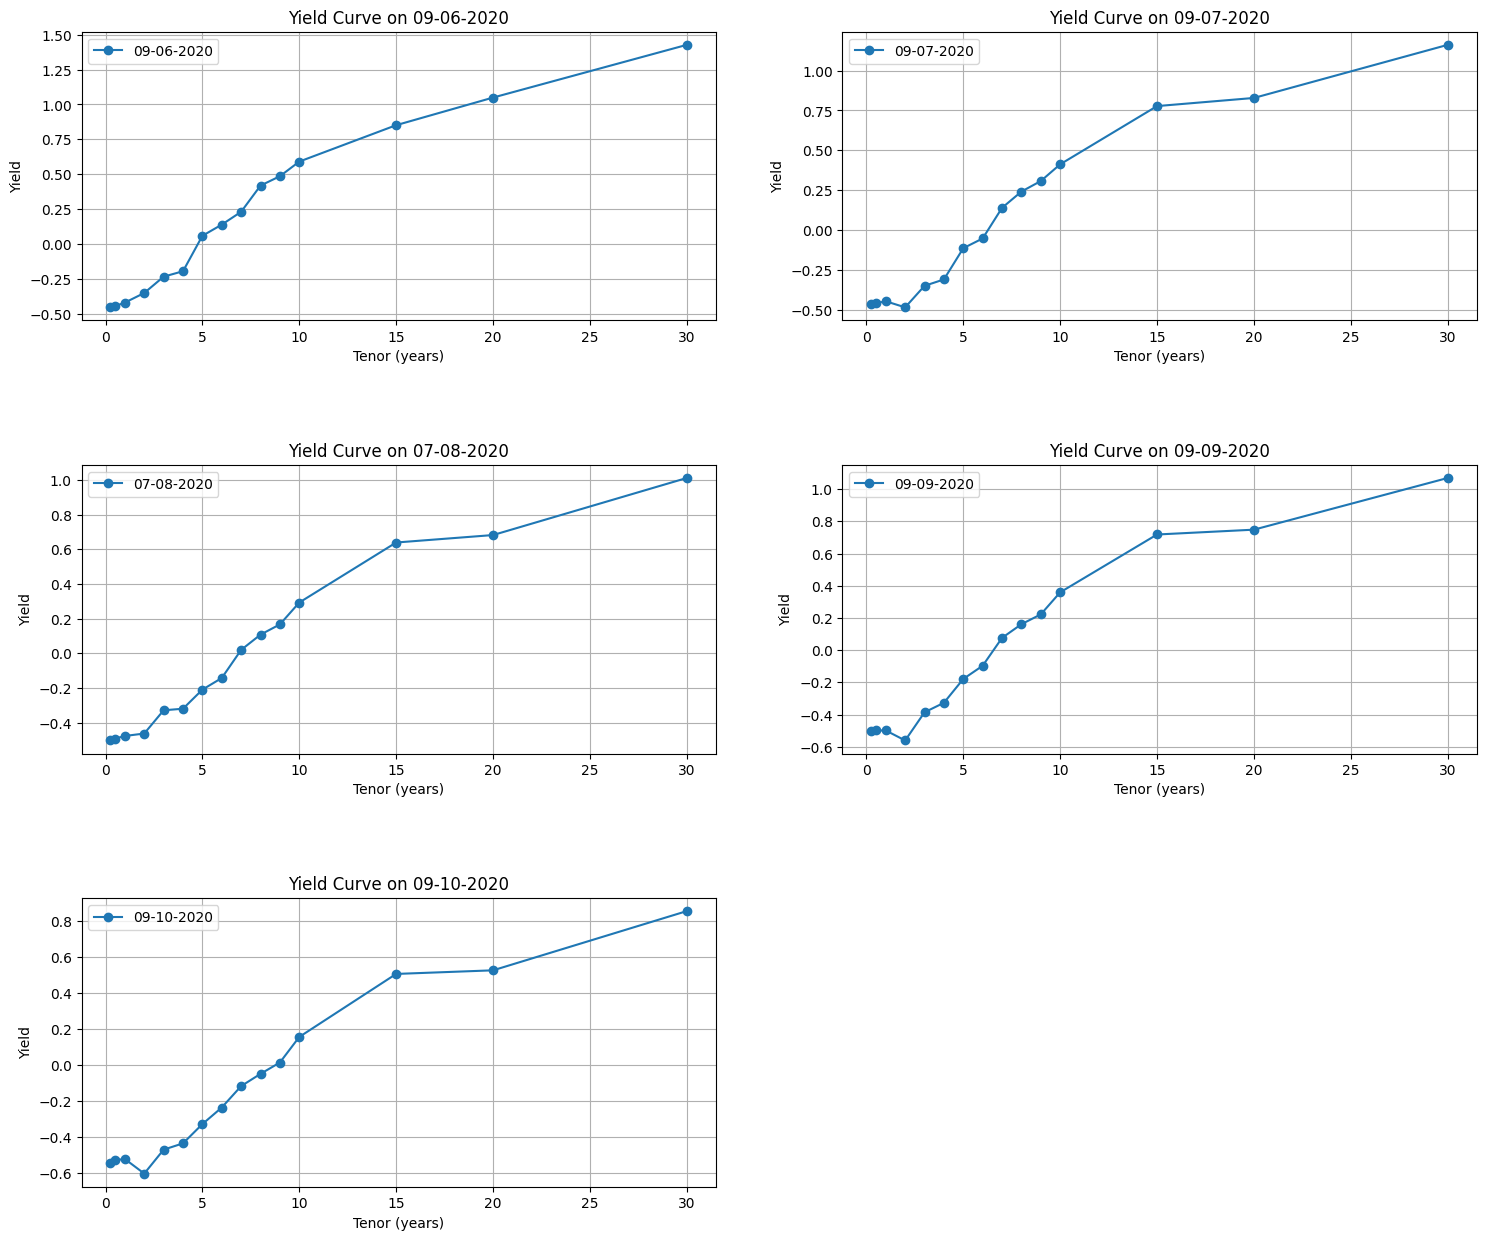

In [4]:
#Plot the yieald curve for each date, individually in subplots
#Subplots organised in two columns

num_rows = len(df.columns) // 2
num_cols = 2

if len(df.columns) % num_cols != 0: 
    num_rows += 1

num_subplots = min(len(df.columns), num_rows * num_cols)
                
fig, axes = plt.subplots(num_rows, num_cols, figsize = (18, 15))

for i, date in enumerate(df.columns):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].plot(df.index, df[date], marker = 'o', linestyle = '-', label = date)
    axes[row, col].set_title(f'Yield Curve on {date}')
    axes[row, col].set_xlabel('Tenor (years)')
    axes[row, col].set_ylabel('Yield')
    axes[row, col].grid()
    axes[row, col].legend()

#In case the number of dates is odd, avoid printing an extra blank plot
if len(df.columns) % num_cols != 0:
    axes[-1, -1].axis('off')
    
plt.subplots_adjust(hspace = 0.5)
plt.show()

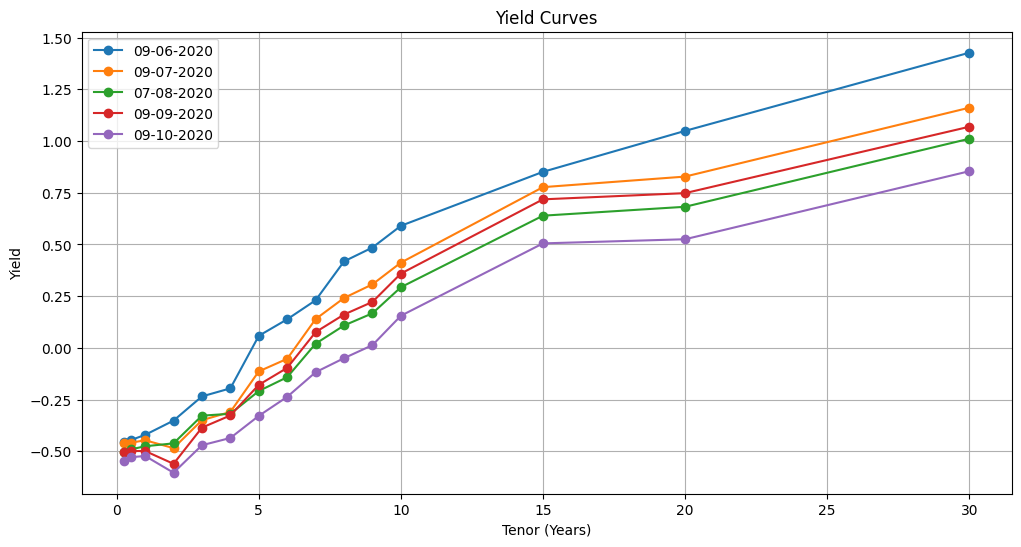

In [5]:
#Plot the yieald curve for each date, together, one line per date
plt.figure(figsize=(12, 6))

for date in df.columns:
    plt.plot(df.index, df[date], marker='o', linestyle='-', label=date)

plt.title('Yield Curves')
plt.xlabel('Tenor (Years)')
plt.ylabel('Yield')
plt.grid()
plt.legend()
plt.show()

**Task**<br>
<br>c) Estimate the NSS parameters for each date

In [6]:
#Import minimize module from scipy.optimize for the optimization (minimization) of the error
from scipy.optimize import minimize

In [7]:
#Definition of the NSS function as per the lectures' slides 
#(Lecture 7 - Regression, Interpolation, Root Finding and Optimization)#

def nss(p, term):
    beta0, beta1, beta2, beta3, tau1, tau2 = p
    return (beta0 
            + beta1 * (1 - np.exp(-term / tau1)) / (term / tau1)
            + beta2 * ((1 - np.exp(-term / tau1)) / (term / tau1) - np.exp(- term / tau1))
            + beta3 * ((1 - np.exp(-term / tau2)) / (term / tau2) - np.exp(- term / tau2)))

In [8]:
#Definition of the error function as per the lectures' slides 
#(Lecture 7 - Regression, Interpolation, Root Finding and Optimization)#

def error(p, x, y):
    return ((nss(p, x) - y) ** 2).sum()

In [9]:
#Definition of the tenors, dates, parameters and creation of the DataFrame for the Parameters Estimated
tenors = df.index.values
dates = df.columns
parameters = ['beta0', 'beta1', 'beta2', 'beta3', 'tau1', 'tau2']
est_params_df = pd.DataFrame(columns = dates, index = parameters)

In [10]:
#initial guess
p0 = np.array([1.2, 0.65, 0.70, 0.085, 1.00, 0.99])
#p0 = np.array([0.01, -0.01, -0.01, -0.001, 2.6, 2.7])

In [11]:
#Calculation of the paramaters
for date in dates:
    x = tenors
    y = df[date].values
        
    p = minimize(error, p0, args=(x, y))['x']
    
    est_params_df[date] = p
    

est_params_df

,09-06-2020,09-07-2020,07-08-2020,09-09-2020,09-10-2020
beta0,17.691481,1.510485,1.359962,1.411887,1.227395
beta1,-18.128427,-1.916101,-1.877393,-1.862587,-1.719379
beta2,-10.210464,-0.558789,0.838268,-0.755856,0.042068
beta3,-42.216057,-2.162494,-4.212155,-2.090680,-2.578220
tau1,4.201846,2.542267,1.450403,2.289783,2.789379
tau2,21.453750,2.543301,2.421679,2.602137,2.916918


**Task** <br>
<br>d) Plot the NSS Yield Curve for each date

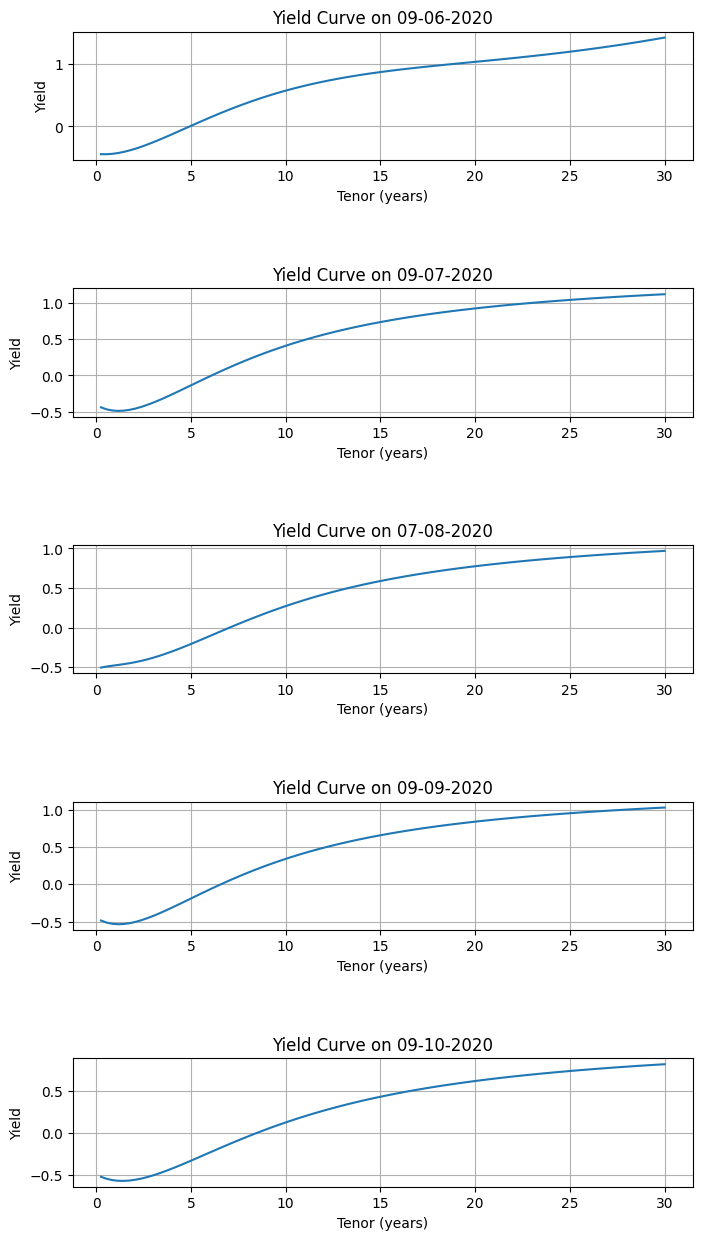

In [12]:
#Plot the NSS yieald curve for each date, individually in subplots
#Subplots organised in one column

fig, ax = plt.subplots(len(df.columns), 1, figsize = (8, 15))
xx = np.linspace(tenors.min(), tenors.max(), 100)

for i, date in enumerate(df.columns):
    
    p = est_params_df[date].values
    nss_yc = np.array([nss(p, t) for t in xx])
                      
    ax[i].plot(xx, nss_yc)
    ax[i].set_title(f'Yield Curve on {date}')
    ax[i].set_xlabel('Tenor (years)')
    ax[i].set_ylabel('Yield')
    ax[i].grid()
    
plt.subplots_adjust(hspace = 1)
plt.show()

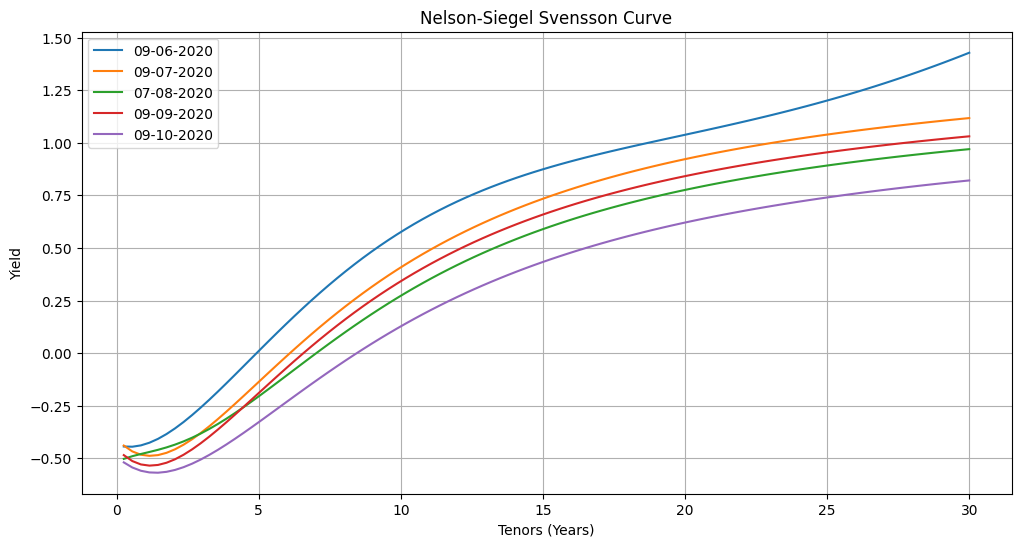

In [13]:
#Plot the NSS yieald curve for each date, grouped together in one graph

plt.figure(figsize=(12,6))
xx = np.linspace(tenors.min(), tenors.max(), 100)

for date in est_params_df.columns:
    p = est_params_df[date].values
    nss_yc = np.array([nss(p, t) for t in xx])
    plt.plot(xx, nss_yc, label = date)
    
plt.title('Nelson-Siegel Svensson Curve')
plt.xlabel('Tenors (Years)')
plt.ylabel('Yield')
plt.grid()
plt.legend()
plt.show()

**Task** <br>
<br>e) Plot the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor)

In [14]:
'''First way to solve this exercise, using the nss function, the parameters calculated for each
date and inputting the new tenors'''

#Definition of a list of the new tenors 
new_tenors = [0.75, 3.5, 12.5, 25]

In [15]:
calc_yld_df = pd.DataFrame(index=new_tenors, columns=est_params_df.columns)

In [16]:
for date in est_params_df.columns:
    params = est_params_df[date].values
    for tenor in new_tenors:
        yield_value = nss(params, tenor)
        calc_yld_df.at[tenor, date] = yield_value
        
calc_yld_df

,09-06-2020,09-07-2020,07-08-2020,09-09-2020,09-10-2020
0.75,-0.441841,-0.479299,-0.483221,-0.525419,-0.555255
3.50,-0.190932,-0.320819,-0.341981,-0.370492,-0.465024
12.50,0.752163,0.594019,0.452042,0.522984,0.299009
25.00,1.200884,1.038988,0.891808,0.954624,0.739994


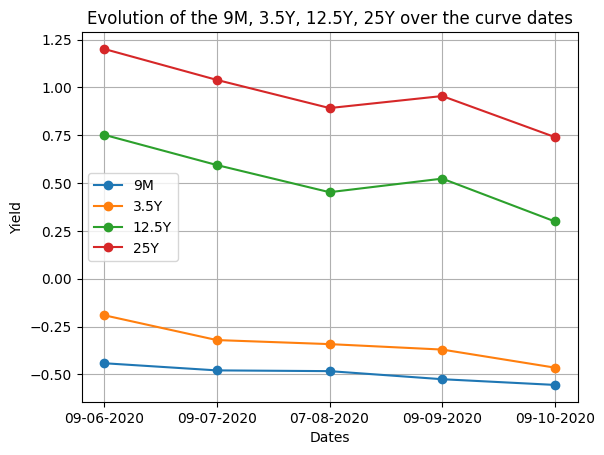

In [17]:
#Plotting of the evolution of the 9M, 3.5Y, 12.5Y and the 25Y over the curve dates (a line for each tenor):
for tenor in new_tenors:
    if tenor < 1:
        plt.plot(calc_yld_df.columns, calc_yld_df.loc[tenor], marker = 'o', label = f'{int(tenor * 12)}M')
    else:
        plt.plot(calc_yld_df.columns, calc_yld_df.loc[tenor], marker = 'o', label = f'{tenor}Y')
    
plt.title("Evolution of the 9M, 3.5Y, 12.5Y, 25Y over the curve dates")
plt.xlabel("Dates")
plt.ylabel('Yield')
plt.grid()
plt.legend()
plt.show()

In [18]:
'''Another possible solution is to interpolate over the new tenors'''

#Importation of the interp1d method from scipy.interpolate
from scipy.interpolate import interp1d

In [19]:
#Creation of an empty list for the subsequent interpolated yields
interpolated_yields = []

#Interpolation and definition of the DataFrame exhibiting the interpolated yields for the tenors requested, 
#for each date

for date in dates:
    current_yields = df[date].values
    interpolation = interp1d(df.index.values, current_yields, kind = 'linear')
    interpolated_yields.append([interpolation(t) for t in new_tenors])

interpolated_yields = [np.round(arr, 6) for arr in interpolated_yields]
intyld_df = pd.DataFrame(interpolated_yields, columns = new_tenors, index = dates).transpose()
intyld_df
#interpolated_yields

,09-06-2020,09-07-2020,07-08-2020,09-09-2020,09-10-2020
0.75,-0.4335,-0.4530,-0.4835,-0.4990,-0.5260
3.50,-0.2155,-0.3300,-0.3235,-0.3565,-0.4535
12.50,0.7205,0.5945,0.4660,0.5385,0.3300
25.00,1.2380,0.9945,0.8465,0.9085,0.6895


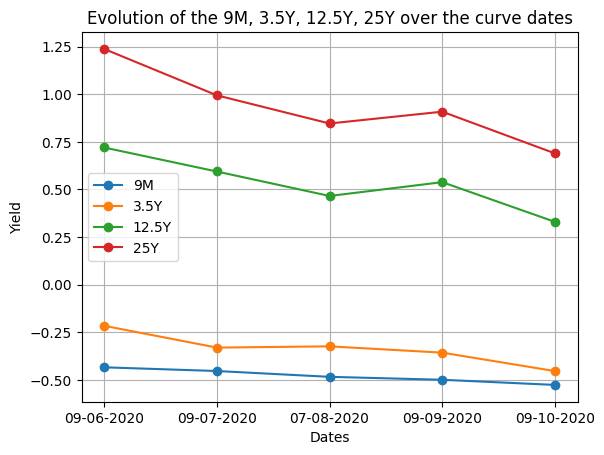

In [20]:
#Plotting of the evolution of the 9M, 3.5Y, 12.5Y and the 25Y over the curve dates (a line for each tenor):
for tenor in new_tenors:
    if tenor < 1:
        plt.plot(dates, intyld_df.loc[tenor], marker = 'o', label = f'{int(tenor * 12)}M')
    else:
        plt.plot(dates, intyld_df.loc[tenor], marker = 'o', label = f'{tenor}Y')
    
plt.title("Evolution of the 9M, 3.5Y, 12.5Y, 25Y over the curve dates")
plt.xlabel("Dates")
plt.ylabel('Yield')
plt.grid()
plt.legend()
plt.show()

**Task** <br>
<br>f) Plot the market data points vs the NSS fit for each date using 5 subplots sharing the y axis (One market date in each subplot)

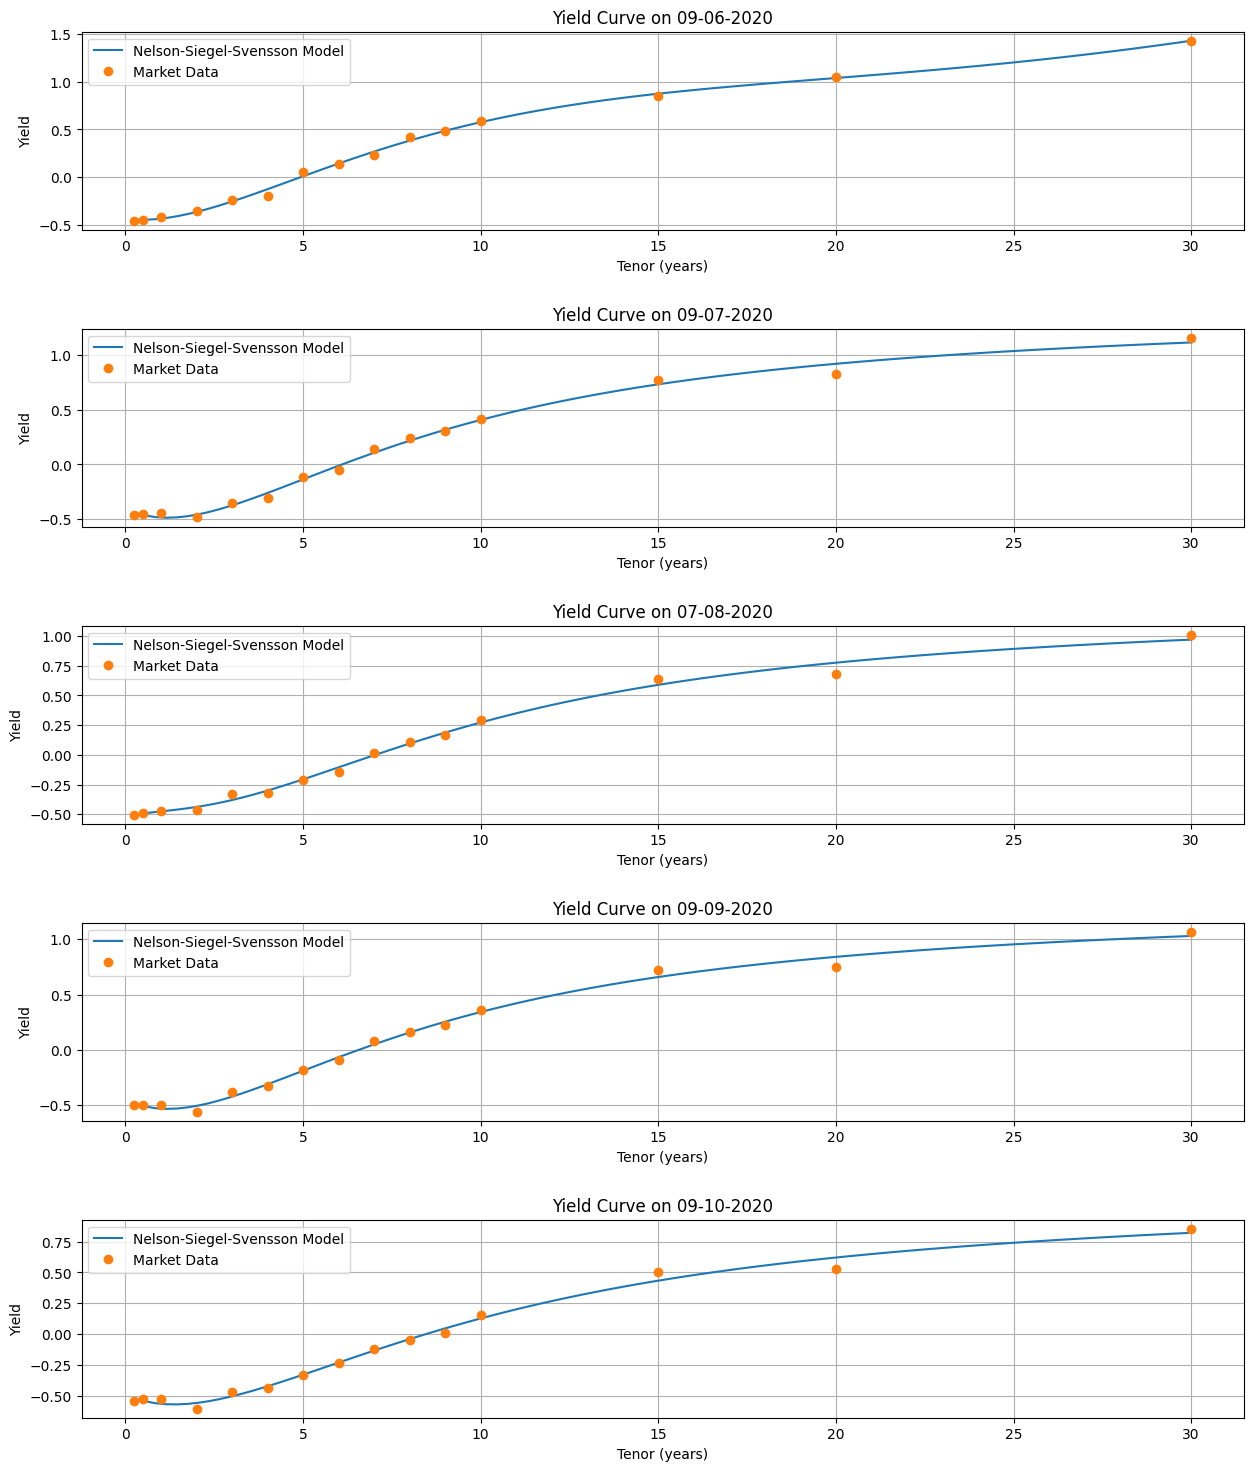

In [21]:
#Plot of the Market Points vs NSS fit organized in subplots (One market date in each subplot)
fig, ax = plt.subplots(len(df.columns), 1, figsize = (15, 18))
xx = np.linspace(tenors.min(), tenors.max(), 100)

for i, date in enumerate(df.columns):
    
    p = est_params_df[date].values
    nss_yc = np.array([nss(p, t) for t in xx])
                      
    ax[i].plot(xx, nss_yc, label = 'Nelson-Siegel-Svensson Model')
    ax[i].plot(tenors, df[date], marker = 'o', linestyle = '', label = 'Market Data')
    ax[i].set_title(f'Yield Curve on {date}')
    ax[i].set_xlabel('Tenor (years)')
    ax[i].set_ylabel('Yield')
    ax[i].grid()
    ax[i].legend()


plt.subplots_adjust(hspace = 0.5)
plt.legend()
plt.show()

**Task** <br>
<br>g) Make a function that will give the daycount fraction between two dates for either convention Act/360 or Act/365 using date strings as inputs.

In [22]:
#Importation of datetime module from datetime package for manipulation of date strings
from datetime import datetime

In [23]:
#Definition of the function dayCount
def dayCount(date1, date2, convention):
    d1 = datetime.strptime(date1, "%d-%m-%Y")
    d2 = datetime.strptime(date2, "%d-%m-%Y")
    if convention not in ["Act/360", "Act/365"]:
        return "Please enter a valid convention (Act/360 or Act/365)"
    elif convention == "Act/360":
        return f'The daycount fraction between {date1} and {date2} is {round(((d2-d1).days/360),2)}'
    else:
        return f'The daycount fraction between {date1} and {date2} is {round(((d2-d1).days/365), 2)}'

Example: dayCount('15-06-2020', '15-12-2021', 'Act/360')

In [24]:
#Example
dayCount('15-06-2020', '15-12-2021', 'Act/360')

'The daycount fraction between 15-06-2020 and 15-12-2021 is 1.52'

**Task** <br>
<br>h) Make a function that not only returns the present value of a future investment for a given rate but also prints a custom string. Example: pv(amount, rate, maturity, text)

In [25]:
#Definition of the PV function
def pv(amount, rate, maturity, text):
    present_value = amount / ((1 + (rate/100)) ** maturity)
    return f"{text} {round(present_value,2)}"

Use it to determine the present value of a payment of EUR 2,430.04 in 5 years at the rate of 5% (Annual compounded rate) and print whatever string you want.

In [26]:
#Example
pv(2430.04, 5, 5, 'The PV of the investment is:')

'The PV of the investment is: 1904.0'